# AutoPhaseNN
#### Pytorch version (under development)

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchinfo import summary
from tqdm.notebook import tqdm 
import numpy as np
from numpy.fft import fftn, fftshift
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.distributed import DistributedSampler
import matplotlib.pyplot as plt
import matplotlib

import params
from data_loader import *

In [5]:
NGPUS = torch.cuda.device_count()
BATCH_SIZE = NGPUS * 64 
LR = NGPUS * params.BASE_LR
print("GPUs:", NGPUS, "Batch size:", BATCH_SIZE, "Learning rate:", LR)

SW_INCREMENT = (params.FINAL_SW-params.INIT_SW)/(params.EPOCHS-1-params.CONST_EPOCHS)
print("SW Thresh increment", SW_INCREMENT)

GPUs: 2 Batch size: 128 Learning rate: 0.0002
SW Thresh increment 0.0005084745762711864


### Plotting

In [3]:
plt.style.use('seaborn-v0_8-white')
#matplotlib.rc('xtick', labelsize=20) 
#matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 20
plt.viridis()
%matplotlib inline

<Figure size 640x480 with 0 Axes>

In [7]:
def plot6(data,titles):
    if(len(titles)<3):
        titles=["Plot1", "Plot2", "Plot3", "Plot4", "Plot5", "Plot6"]
    ind = data[0].shape[0]//2
    fig, axes = plt.subplots(1,6, figsize=(19,3), constrained_layout=True)
    for ix, ax in enumerate(axes):
        im=ax.imshow(data[ix][ind])
        plt.colorbar(im, ax=ax)
        ax.set_title(titles[ix])

### Load and check data, then prepare as tensors

In [8]:
# # data loader

dataname_list = os.path.join(params.data_path, '3D_upsamp.txt')
filelist = []

with open(dataname_list, 'r') as f:
    txtfile = f.readlines()
for i in range(len(txtfile)):
    tmp = str(txtfile[i]).split('/')[-1]
    tmp = tmp.split('\n')[0]

    filelist.append(tmp)
f.close()
print('number of available file:%d' % len(filelist))

# give training data size and filelist
# train_file_indxs = np.random.randint(len(filelist), size=N_TRAIN).astype('int')
# train_filelist = [filelist[idx] for idx in train_file_indxs]
train_filelist = filelist[:params.N_TRAIN]
print('number of training:%d' % len(train_filelist))


number of available file:54028
number of training:5000


In [9]:
# load training data and validation data
train_dataset = Dataset(
    train_filelist, params.data_path, load_all=False, 
    ratio=params.TRAIN_ratio, dataset='train',scale_I=params.scale_I)
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NGPUS*4)
# train_sampler = DistributedSampler(
#     train_dataset, num_replicas=NGPUS, rank=rank, shuffle=True)
# train_loader = DataLoader(
#     train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, shuffle=False, num_workers=NGPUS*8)


validation_dataset = Dataset(
    train_filelist, params.data_path, load_all=False, ratio=params.TRAIN_ratio, 
    dataset='validation',scale_I=params.scale_I)
validation_loader = DataLoader(
    validation_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NGPUS*4)
# validation_sampler = DistributedSampler(
#     validation_dataset, num_replicas=NGPUS, rank=rank, shuffle=True)
# validation_loader = DataLoader(
#     validation_dataset, batch_size=BATCH_SIZE, sampler=validation_sampler, shuffle=False, num_workers=NGPUS*8)

### Check the model works

In [10]:
from model import recon_model

In [11]:
model = recon_model()
for ft_images,amps,phs in train_loader:
    print("batch size:", ft_images.shape, amps.shape, phs.shape)
    #outs = model(ft_images)
    #print(*[o.shape for o in outs])
    #print(*[o.dtype for o in outs])
    y, complex_x, amp, ph, _ = model(ft_images)
    print(y.shape, complex_x.shape, amp.shape, ph.shape)
    print(y.dtype, complex_x.dtype, amp.dtype, ph.dtype)
    break

batch size: torch.Size([128, 1, 64, 64, 64]) torch.Size([128, 1, 64, 64, 64]) torch.Size([128, 1, 64, 64, 64])
torch.Size([128, 1, 64, 64, 64]) torch.Size([128, 1, 64, 64, 64]) torch.Size([128, 1, 64, 64, 64]) torch.Size([128, 1, 64, 64, 64])
torch.float32 torch.complex64 torch.float32 torch.float32


In [12]:
summary(model, (1, 1, 64,64,64), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
recon_model                              [1, 1, 64, 64, 64]        --
├─Sequential: 1-1                        [1, 256, 4, 4, 4]         --
│    └─Conv3d: 2-1                       [1, 32, 64, 64, 64]       896
│    └─LeakyReLU: 2-2                    [1, 32, 64, 64, 64]       --
│    └─BatchNorm3d: 2-3                  [1, 32, 64, 64, 64]       64
│    └─Conv3d: 2-4                       [1, 64, 32, 32, 32]       55,360
│    └─LeakyReLU: 2-5                    [1, 64, 32, 32, 32]       --
│    └─BatchNorm3d: 2-6                  [1, 64, 32, 32, 32]       128
│    └─Conv3d: 2-7                       [1, 64, 32, 32, 32]       110,656
│    └─LeakyReLU: 2-8                    [1, 64, 32, 32, 32]       --
│    └─BatchNorm3d: 2-9                  [1, 64, 32, 32, 32]       128
│    └─Conv3d: 2-10                      [1, 128, 16, 16, 16]      221,312
│    └─LeakyReLU: 2-11                   [1, 128, 16, 16, 16]      -

### Move model to appropriate device

In [13]:
model = recon_model()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if NGPUS > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model) #Default all devices

model = model.to(device)

Let's use 2 GPUs!


### Setup optimizer and cyclicLR

In [14]:
#Optimizer details
iterations_per_epoch = np.floor((params.N_TRAIN*params.TRAIN_ratio)/BATCH_SIZE)+1 #Final batch will be less than batch size
step_size = 6*iterations_per_epoch #Paper recommends 2-10 number of iterations, step_size is half cycle
print("LR step size is:", step_size, "which is every %d epochs" %(step_size/iterations_per_epoch))

criterion = nn.L1Loss()
optimizer = torch.optim.AdamW(model.parameters(), lr = LR) #Adam with weight decay
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=LR, 
                                              max_lr=LR*5, step_size_up=step_size,
                                              cycle_momentum=False, mode='triangular2')

LR step size is: 216.0 which is every 6 epochs


## Training and Validation Loop

In [15]:
#Function to update saved model if validation loss is minimum
def update_saved_model(model, path):
    if not os.path.isdir(path):
        os.mkdir(path)
    for f in os.listdir(path):
        os.remove(os.path.join(path, f))
    if NGPUS > 1:
        torch.save(model.module.state_dict(),path+'best_model.pth') #Have to save the underlying model else will always need 4 GPUs
    else:
        torch.save(model.state_dict(),path+'best_model.pth')

In [19]:
def train(trainloader,metrics):
    loss_ft = 0.0
    loss_amp = 0.0
    loss_ph = 0.0
    
    for i, (ft_images,amps,phs) in tqdm(enumerate(trainloader)):
        ft_images = ft_images.to(device) #Move everything to device
        amps = amps.to(device)
        phs = phs.to(device)

        y, _, pred_amps, pred_phs, support = model(ft_images) #Forward pass
        
        #Compute losses
        loss_f = criterion(y, ft_images)
        loss_a = criterion(pred_amps,amps) #Monitor amplitude loss
        loss_p = criterion(pred_phs*support,phs) #Monitor phase loss but only within support (which may not be same as true amp)
        loss = loss_f #Use only FT loss for gradients
        #loss = loss_a + loss_p + loss_f

        #Zero current grads and do backprop
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()

        loss_ft += loss_f.detach().item()
        loss_amp += loss_a.detach().item()
        loss_ph += loss_p.detach().item()
        #loss_ft = 0

        #Update the LR according to the schedule -- CyclicLR updates each batch
        scheduler.step() 
        metrics['lrs'].append(scheduler.get_last_lr())
        
        
    #Divide cumulative loss by number of batches-- sli inaccurate because last batch is different size
    metrics['losses'].append([loss_ft/i,loss_amp/i,loss_ph/i]) 
    

def validate(validloader,metrics):
    val_loss_ft = 0.0
    val_loss_amp = 0.0
    val_loss_ph = 0.0
    for j, (ft_images,amps,phs) in enumerate(validloader):
        ft_images = ft_images.to(device)
        amps = amps.to(device)
        phs = phs.to(device)
        y, _, pred_amps, pred_phs, support = model(ft_images) #Forward pass
        #pred_amps, pred_phs, support = model(ft_images) #Forward pass
    
        val_loss_f = criterion(y, ft_images)
        val_loss_a = criterion(pred_amps,amps) 
        val_loss_p = criterion(pred_phs*support,phs) 
    
        val_loss_ft += val_loss_f.detach().item()
        val_loss_amp += val_loss_a.detach().item()
        val_loss_ph += val_loss_p.detach().item()  
        
    metrics['val_losses'].append([val_loss_ft/j,val_loss_amp/j,val_loss_ph/j])
    
  #Update saved model if val loss is lower
    if(val_loss_ft/j<metrics['best_val_loss']):
        print("Saving improved model after Val Loss improved from %.5f to %.5f" %(metrics['best_val_loss'],val_loss_ft/j))
        metrics['best_val_loss'] = val_loss_ft/j
        update_saved_model(model, params.MODEL_SAVE_PATH)

In [20]:
metrics = {'losses':[],'val_losses':[], 'lrs':[], 'best_val_loss' : np.inf}

for epoch in tqdm(range(params.EPOCHS)):
    
    #Set model to train mode
    model.train() 

    #Training loop
    train(train_loader,metrics)

    #Switch model to eval mode
    model.eval()

#     Validation loop
    validate(validation_loader,metrics)
    l = metrics['losses'][-1]
    lv =  metrics['val_losses'][-1]

    print(f'Epoch: {epoch} | FT  | Train Loss: {l[0]:.5f} | Val Loss: {lv[0]:.5f}')
    print(f'Epoch: {epoch} | Amp | Train Loss: {l[1]:.4f} | Val Loss: {lv[1]:.5f}')
    print(f'Epoch: {epoch} | Ph  | Train Loss: {l[2]:.3f} | Val Loss: {lv[2]:.5f}')
    if NGPUS>1:
        print(f'Epoch: {epoch} | SW Thresh: {model.module.sw_thresh:.4f}')
    else:
        print(f'Epoch: {epoch} | SW Thresh: {model.sw_thresh:.4f}')
           
    print(f'Epoch: {epoch} | Ending LR: {metrics["lrs"][-1][0]:.6f}')

    if(epoch>=(params.CONST_EPOCHS-1)): #Keep SW thresh =0 i.e fixed half box support for first N epochs
        if NGPUS>1:
            model.module.sw_thresh+=SW_INCREMENT #Update shrink-wrap threshold every epoch
        else:
            model.sw_thresh+=SW_INCREMENT #Update shrink-wrap threshold every epoch

  0%|          | 0/60 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Saving improved model after Val Loss improved from inf to 0.00262
Epoch: 0 | FT  | Train Loss: 0.00184 | Val Loss: 0.00262
Epoch: 0 | Amp | Train Loss: 0.0370 | Val Loss: 0.04486
Epoch: 0 | Ph  | Train Loss: 0.100 | Val Loss: 0.11781
Epoch: 0 | SW Thresh: 0.0700
Epoch: 0 | Ending LR: 0.000600


0it [00:00, ?it/s]

Saving improved model after Val Loss improved from 0.00262 to 0.00237
Epoch: 1 | FT  | Train Loss: 0.00181 | Val Loss: 0.00237
Epoch: 1 | Amp | Train Loss: 0.0306 | Val Loss: 0.03688
Epoch: 1 | Ph  | Train Loss: 0.079 | Val Loss: 0.09315
Epoch: 1 | SW Thresh: 0.0705
Epoch: 1 | Ending LR: 0.000733


0it [00:00, ?it/s]

KeyboardInterrupt: 

Text(0.5, 0, 'Epoch')

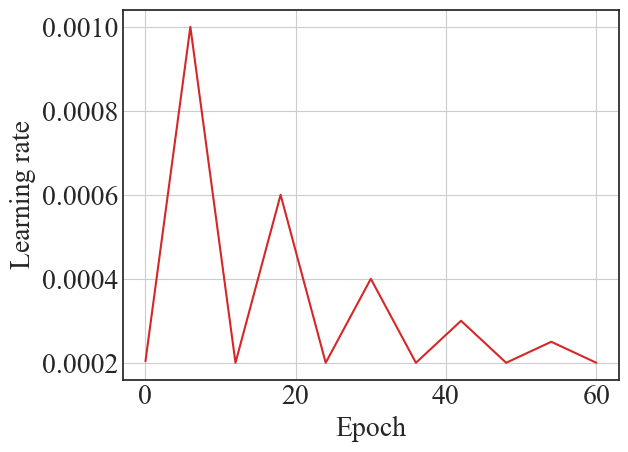

In [ ]:
batches = np.linspace(0,len(metrics['lrs']),len(metrics['lrs'])+1)
epoch_list = batches/iterations_per_epoch

plt.plot(epoch_list[1:],metrics['lrs'], 'C3-')
plt.grid()
plt.ylabel("Learning rate")
plt.xlabel("Epoch")

Text(0.5, 51.583333333333314, 'Epochs')

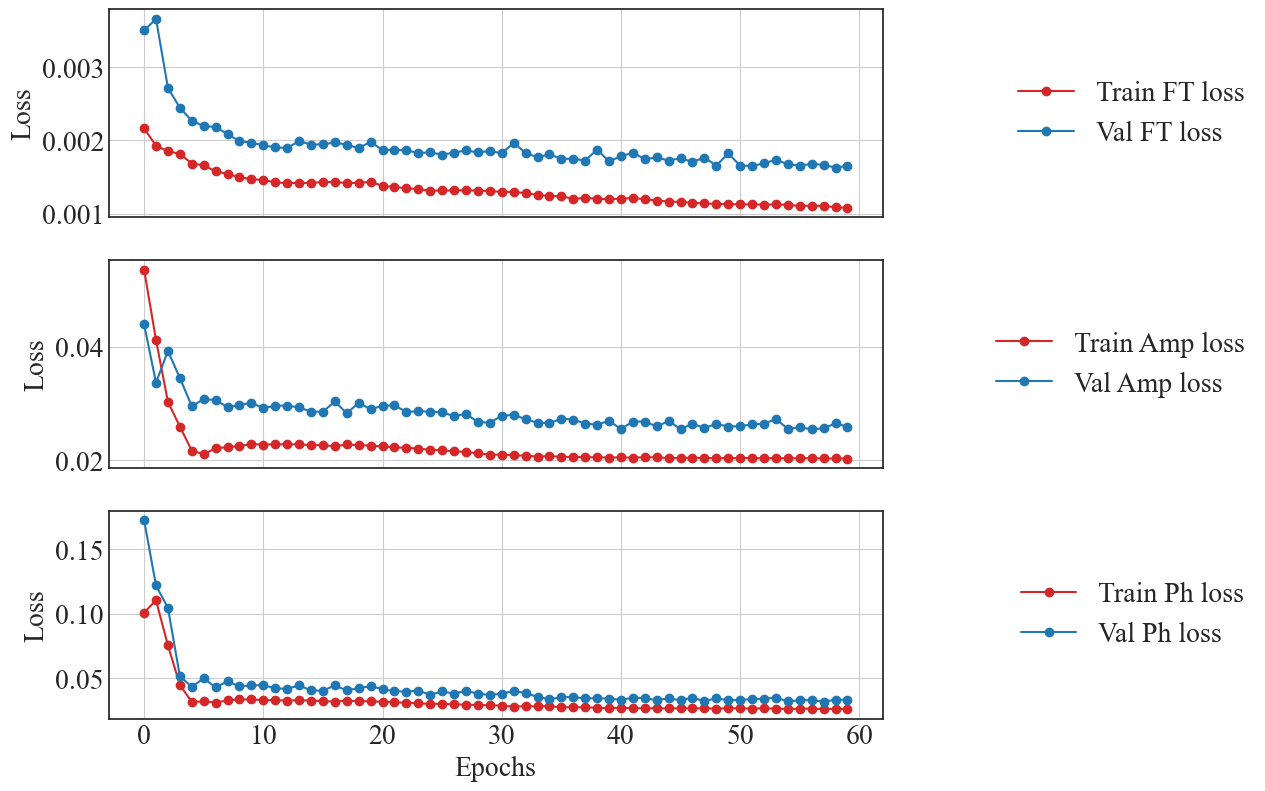

In [ ]:
losses_arr = np.array(metrics['losses'])
val_losses_arr = np.array(metrics['val_losses'])
losses_arr.shape
fig, ax = plt.subplots(3,sharex=True, figsize=(15, 8))
ax[0].plot(losses_arr[:,0], 'C3o-', label = "Train FT loss")
ax[0].plot(val_losses_arr[:,0], 'C0o-', label = "Val FT loss")
ax[0].set(ylabel='Loss')
ax[0].grid()
ax[0].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
ax[1].plot(losses_arr[:,1], 'C3o-', label = "Train Amp loss")
ax[1].plot(val_losses_arr[:,1], 'C0o-', label = "Val Amp loss")
ax[1].set(ylabel='Loss')
ax[1].grid()
ax[1].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
ax[2].plot(losses_arr[:,2], 'C3o-', label = "Train Ph loss")
ax[2].plot(val_losses_arr[:,2], 'C0o-', label = "Val Ph loss")
ax[2].set(ylabel='Loss')
ax[2].grid()
ax[2].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))

plt.tight_layout()
plt.xlabel("Epochs")
